### Setup

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import time
from pathlib import Path
from tqdm import tqdm

import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
from jax import nn
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import os, sys

# add path above this one
sys.path.append(str(Path(os.path.abspath('')).parent))
                
import utils

In [116]:
# Get name images, convert to 8-bit (x3) binary code for RGB
name_images = np.load(utils.get_name_images_path())
binary_images = utils.image_to_binary(name_images)
return_images = utils.binary_to_image(binary_images)
print(np.allclose(name_images, return_images))
print(np.all(np.logical_or(binary_images==0, binary_images==1)))

True
True


In [31]:
use_binary_images = True
if use_binary_images:
    images = np.load(utils.get_name_images_path())
    using_color = (images.shape[-1] == 3) and (images.ndim==4)
    if using_color:
        images = utils.image_to_binary(images)

else:
    root = '/Users/maximebeau/Library/CloudStorage/Dropbox/Zettel/Notes/MBL MCN/Tutorials'

    path = Path(root) / 'hopfield_names_MCN_2024_firstnames.npy'
    images = np.load(path)


images = 2. * images - 1.
images = jnp.array(images)

filter_by_used = False
P = images.shape[0]
full_patterns = images.reshape((P, -1)).astype(jnp.float32)
if using_color:
    if filter_by_used:
        idx_used = np.any(full_patterns == 1, axis=0)
    else:
        images_plus = np.copy(images)
        add_bits_idx = [7, 15, 23]
        images_plus[:, :, add_bits_idx] = 1
        full_patterns_plus = images_plus.reshape((P, -1)).astype(jnp.float32)
        idx_used = np.any(full_patterns_plus == 1, axis=0)
else:
    idx_used = np.ones(full_patterns.shape[-1], dtype=bool)
memory_patterns = full_patterns[:, idx_used]

In [19]:
images.shape

(67, 20, 93, 24)

In [20]:
full_patterns_plus.shape, memory_patterns.shape

((67, 44640), (67, 26035))

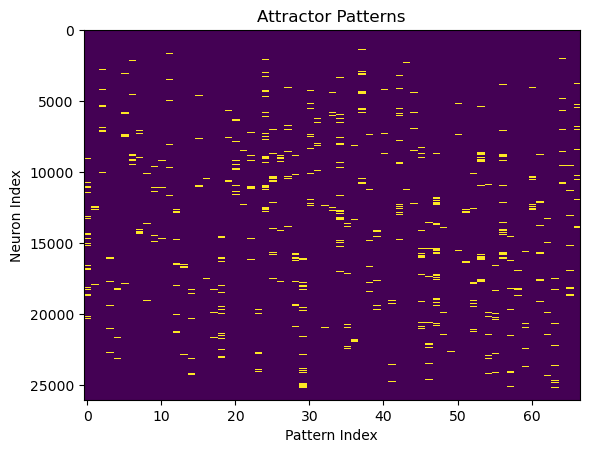

In [21]:
# memory_patterns = generate_random_pattern(key, (P, N))

plt.close('all')
plt.imshow(memory_patterns.T, interpolation='none', aspect='auto')
plt.title('Attractor Patterns')
plt.xlabel('Pattern Index')
plt.ylabel('Neuron Index')
plt.show()

In [32]:
use_pseudo = True
if use_pseudo:
    claude = True
    if claude:
        W = utils.pseudo_inverse_learning(memory_patterns)
    else:
        W = utils.pseudo_inv(memory_patterns)
else:
    W = utils.hebbian_weights(memory_patterns)

show_weights = False
if show_weights:
    plt.imshow(jnp.abs(W) > 5, vmin=0, vmax=1, interpolation='none', cmap='Greys')

In [23]:
W.shape

(26035, 26035)

In [24]:
W.min()

Array(-0.00271185, dtype=float32)

### Test Retrieval

In [33]:
one_step = utils.simulate_probabilistic(memory_patterns, W, b=0, beta=0.05, num_iters=10)
print(jnp.all(memory_patterns == one_step[-1]))
print(jnp.sum(memory_patterns == one_step[-1]) / memory_patterns.size)

# random_deviations = utils.sign(memory_patterns + 3*np.random.randn(*memory_patterns.shape))
# one_step = utils.simulate(random_deviations, W, b=-0.01, num_iters=4)
# print(jnp.all(random_deviations == one_step[-1]))
# print(jnp.all(memory_patterns == one_step[-1]))


True
1.0


In [34]:
def run_simulations(memory_patterns, W, sigma=5, b=1e-2, start_beta=0.5, end_beta=0.0001, num_per_name=5, max_attempts=5, max_T=10):
    P, N = memory_patterns.shape
    name_simulations = []
    name_success = []
    name_attempts = []
    for p in tqdm(range(P)):
        success = False
        attempts = 0
        while not success:
            noise_patterns = np.repeat(memory_patterns[p][np.newaxis], num_per_name, axis=0) + sigma * np.random.randn(num_per_name, N)
            results = utils.simulate_probabilistic(noise_patterns, W, b=b, beta=start_beta, end_beta=end_beta, num_iters=max_T)
            converged = np.all(results[-1] == memory_patterns[p], axis=1)
            success = np.all(converged).item()
            attempts += 1
            if attempts > max_attempts:
                break
        if success:
            stacked_results = np.transpose(results, axes=(1, 0, 2)).reshape(-1, N)
            name_simulations.append(stacked_results)
        else:
            name_simulations.append(results)
        name_attempts.append(attempts)
        name_success.append(success)
    return name_simulations, name_success, name_attempts

In [35]:
sims, success, attempts = run_simulations(memory_patterns[:2], W, start_beta=5.0, end_beta=0.01, num_per_name=5)

100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


In [73]:
from PIL import Image

def create_gif(filename, images, scaleup=1, duration=100):
    num_frames = images.shape[0]
    frames = []
    for i in range(num_frames):
        frame = Image.fromarray(images[i])
        frames.append(frame)

    if scaleup is not None:
        original_shape = images[0].shape
        new_shape = (original_shape[1]*scaleup, original_shape[0]*scaleup)
        frames = [f.resize(new_shape) for f in frames]

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], 
                   optimize=False, duration=duration, loop=0)

In [29]:
iname = 0

asim_activity = -1. * np.ones((sims[iname].shape[0], full_patterns.shape[1]))
asim_activity[:, idx_used] = sims[iname]
asim_binary = ((asim_activity + 1.0) // 2).astype(bool)

sim_images = np.reshape(asim_binary, (asim_binary.shape[0], images.shape[1], images.shape[2], 24))
rgb_images = utils.binary_to_image(sim_images)

# create_gif('simulated_names.gif', rgb_images, scaleup=10, duration=100)

print(rgb_images.shape)


from matplotlib.animation import FuncAnimation

# Create the figure and axis
fig, ax = plt.subplots()

# Initialize the image plot
im = ax.imshow(rgb_images[0], animated=True)

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Function to update the image for each frame
def update(frame):
    im.set_array(rgb_images[frame])
    ax.set_title(f'Frame {frame + 1}/{rgb_images.shape[0]}')
    return [im]

# Create the animation
anim = FuncAnimation(fig, update, frames=rgb_images.shape[0], interval=120, blit=True)

plt.close(fig)

# Convert the animation to HTML5 video
from IPython.display import Javascript, HTML

js_anim = anim.to_jshtml()
HTML(js_anim)


(55, 20, 93, 3)


In [357]:
P, N = memory_patterns.shape

num_sim = 5

use_noise = False
if use_noise:
    key = jr.key(int(time.time()))
    noise_patterns = utils.generate_random_pattern(key, (num_sim, N))
else:
    idx_simulated = np.random.permutation(P)[:num_sim]
    noise_patterns = utils.sign(memory_patterns + 5 * np.random.randn(*memory_patterns.shape))
    print("% Difference (average):", 100*np.sum(noise_patterns != memory_patterns) / memory_patterns.size)
    noise_patterns = noise_patterns[idx_simulated]

print(noise_patterns.shape)

T = 10
simulation = utils.simulate_probabilistic(noise_patterns, W, b=1e-2, beta=0.3, end_beta=0.001, num_iters=T)

if not use_noise:
    for ns in range(num_sim):
        perfect = np.allclose(simulation[-1, ns], memory_patterns[idx_simulated[ns]])
        accuracy = np.sum(simulation[-1, ns] == memory_patterns[idx_simulated[ns]]) / simulation[-1, ns].size
        print(ns, perfect, accuracy)


% Difference (average): 42.08184
(5, 19930)
0 True 1.0
1 True 1.0
2 True 1.0
3 True 1.0
4 True 1.0


(11, 5, 20, 93, 3)


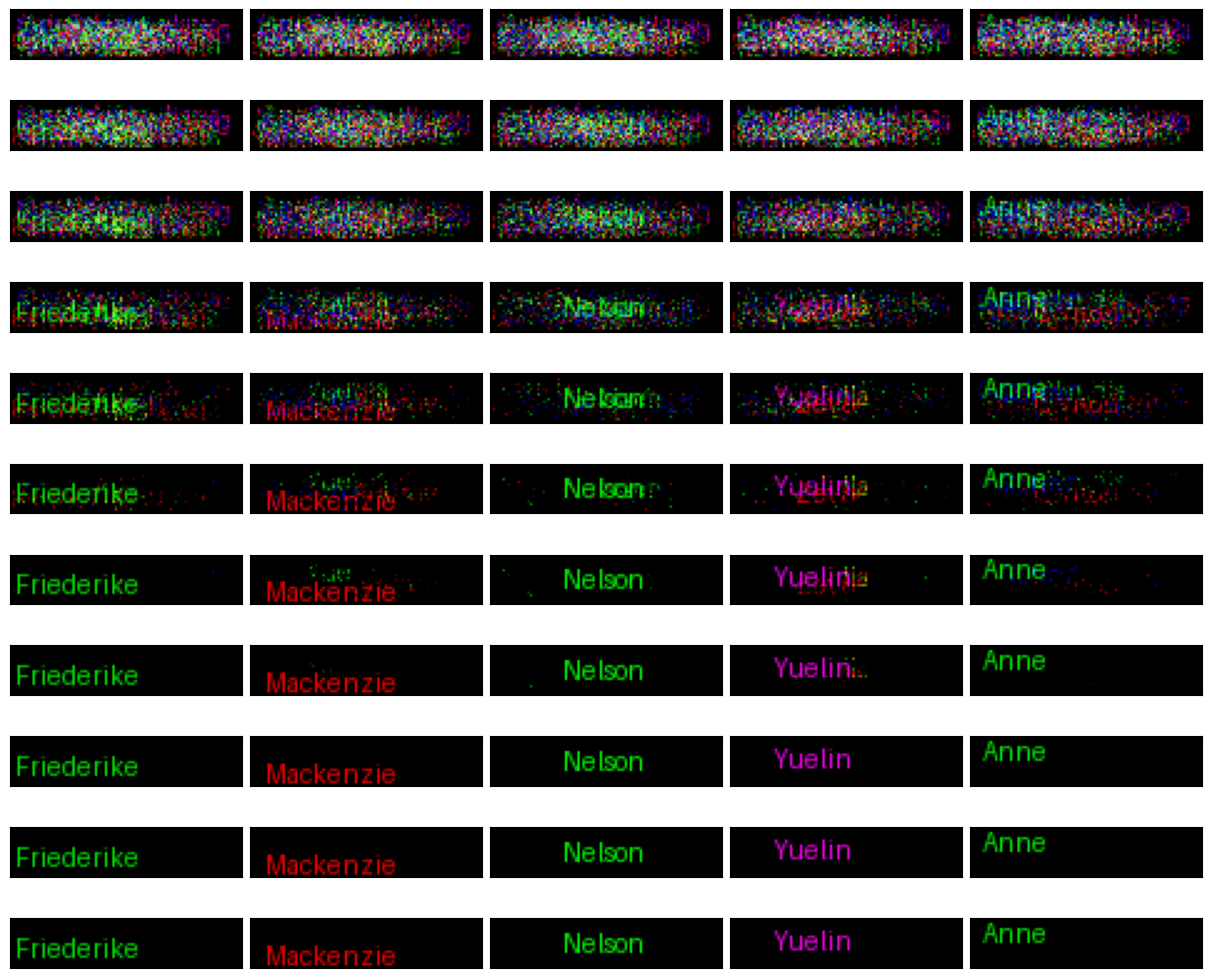

In [359]:
sim_activity = -1. * np.ones((T+1, num_sim, full_patterns.shape[1]))
sim_activity[:, :, idx_used] = simulation
sim_binary = ((sim_activity + 1.0) // 2).astype(bool)

if using_color:
    sim_images = np.reshape(sim_binary, (T+1, num_sim, images.shape[1], images.shape[2], 24))
    rgb_images = utils.binary_to_image(sim_images)

    print(rgb_images.shape)
else:
    rgb_images = np.reshape(sim_activity, (T+1, num_sim, images.shape[1], images.shape[2]))

fig, ax = plt.subplots(T+1, num_sim, figsize=(12, 1*T), layout="constrained")
for i in range(T+1):
    for j in range(num_sim):
        ax[i, j].imshow(rgb_images[i][j])
        ax[i,j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()    

In [39]:
# noise_images = noise_patterns.reshape((-1, *images.shape[1:]))

# noise_images = noise_images.at[..., :40].set(-1)
# noise_images = noise_images.at[..., -40:].set(-1)
# plt.imshow(noise_images[0])
# plt.show()

# noise_patterns = noise_images.reshape((20, -1))
# simulation = simulate(noise_patterns, W, num_iters=T)

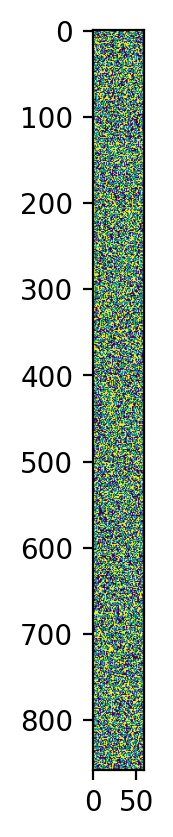

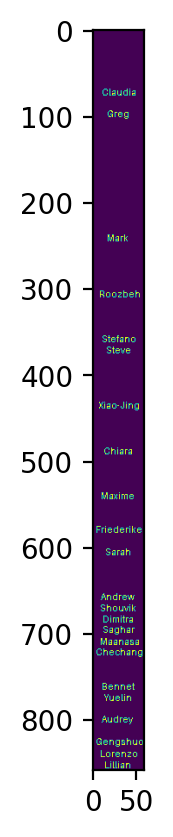

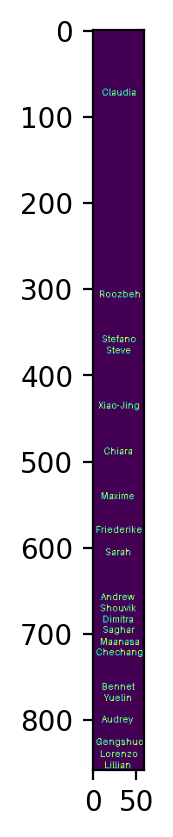

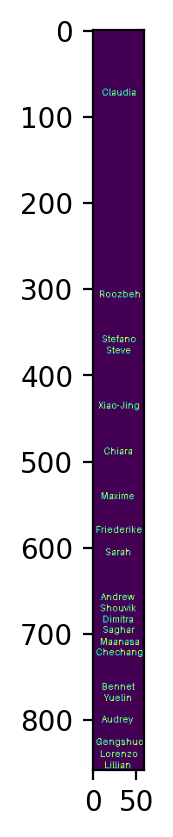

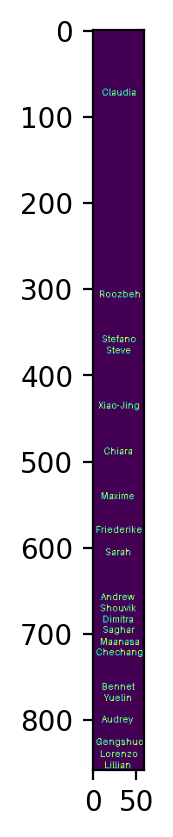

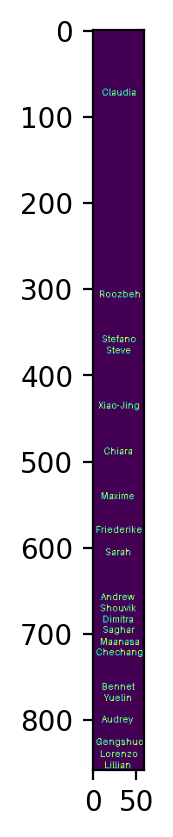

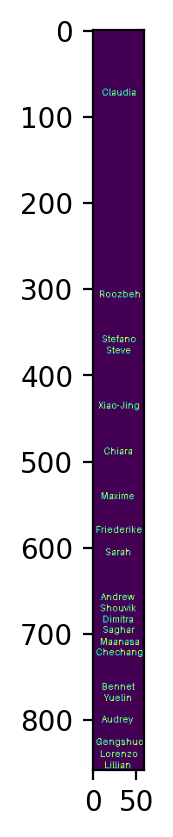

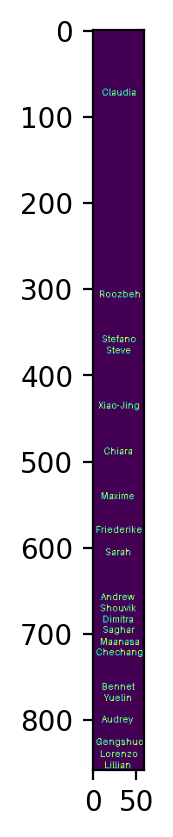

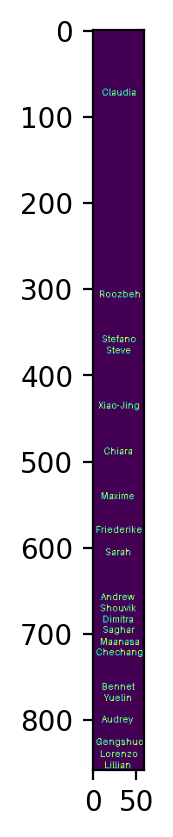

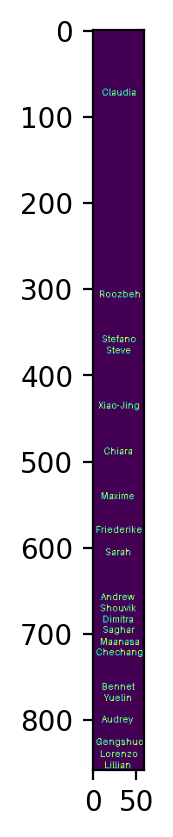

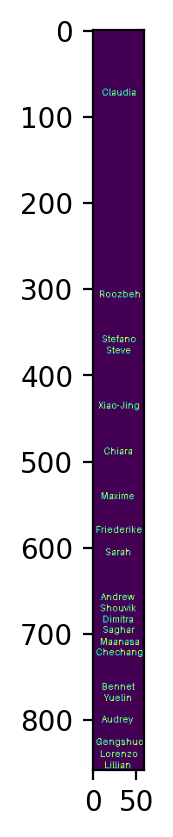

In [40]:
i = -1

for frame in simulation[:, i, :]:
  plt.imshow(frame.reshape(images.shape[1:]))
  plt.show()

In [75]:
@partial(jit, static_argnames='num_iters')
def simulate(x_0, W, b=0, num_iters=10):
    def _step(x_t, b_t):
      x_tp1 = sign(jnp.einsum('ij,...i->...j', W, x_t) - b_t)
      return x_tp1, x_tp1

    N = x_0.shape[-1]
    b = jnp.zeros((num_iters, *x_0.shape))
    _, x = jax.lax.scan(_step, x_0, b)
    x = jnp.r_[x_0[jnp.newaxis], x]
    return x

In [76]:
@partial(jit, static_argnames='num_iters')
def annealing_simulation(x_0, W, key=jr.PRNGKey(0), num_iters=10):
    def _step(x_t, carry):
      key,
      x_tp1 = sign(jnp.einsum('ij,...i->...j', W, x_t) - b_t)
      return x_tp1, x_tp1

    N = x_0.shape[-1]
    b = jnp.zeros((num_iters, *x_0.shape))
    _, x = jax.lax.scan(_step, x_0, b)
    x = jnp.r_[x_0[jnp.newaxis], x]
    return x

# Annealing

In [16]:
def sigmoid(x, beta=1):
  return 1 / (1 + np.exp(-beta * x))

def annealing_simulation(x0, W, beta_schedule):
  num_units = len(x0)
  num_iters = len(beta_schedule)

  i = np.random.choice(num_units, num_iters)
  random_tape = np.random.random(num_iters)

  x = np.empty((num_iters + 1, num_units))
  x[0] = x0
  for t in range(num_iters):
    h_i_t = W[i[t]] @ x[t]
    p_i_t = sigmoid(h_i_t, beta_schedule[t])
    x_i_tp1 = 2 * (random_tape[t] < p_i_t) - 1

    x[t + 1] = x[t]
    x[t + 1, i] = x_i_tp1
  return x

In [55]:
# num_iters = 1000
# beta_max = 20
# np.exp(np.linspace(0, 1, num_iters) - np.exp(1))
# beta_schedule = beta_max * np.exp(np.linspace(0, 1, num_iters)) / np.exp(1)

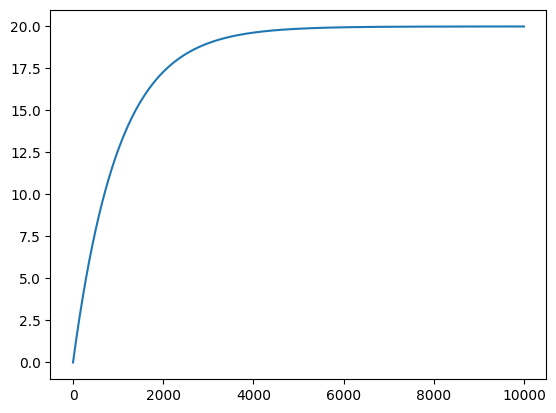

In [59]:
num_iters = 10000
beta_max = 20
np.exp(np.linspace(-1, 0, num_iters) - np.exp(1))

beta_max = 20

tau = -10
decay_series = -1 * np.exp(tau * np.linspace(0, 1, num_iters)) + 1
beta_schedule = decay_series * beta_max
plt.plot(beta_schedule)
plt.show()

In [60]:
x0 = 2 * (np.random.random(N) > .5) - 1
x = annealing_simulation(x0, W, beta_schedule).reshape((-1, *images.shape[1:]))

<ipython-input-16-f4a2cd315b92>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-beta * x))


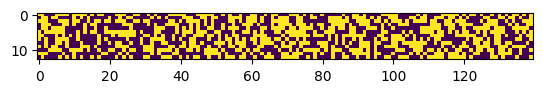

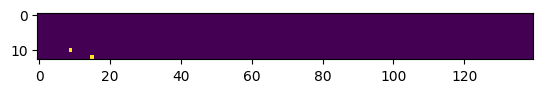

In [61]:
# for frame in x:
#   plt.imshow(frame)
#   plt.show()

plt.imshow(x[0])
plt.show()

plt.imshow(x[-1])
plt.show()

# Misc

In [ ]:
num_test = 1000
N = p.shape[-1]
num_flip = 10
# p_target = np.array(p[0])
p_corrupt = np.ones((num_test, N)) * np.array(p[0])

for i in range(num_test):
  flips = np.random.choice(N, num_flip, replace=False)
  p_corrupt[i, flips] *= -1
p_corrupt = jnp.array(p_corrupt)

In [ ]:
percent_stable_arr = np.zeros(N)
percent_stable_arr[0] = 1
for i in range(1, N):
  W = pseudo_inv(p[:i])
  x = simulate_ein(p_corrupt, W, num_iters=20)
  is_stable = jnp.all(x[-1] == p[0], axis=-1)
  percent_stable = is_stable.sum() / len(is_stable)
  print(percent_stable)
  percent_stable_arr[i] = percent_stable

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999
0.999
0.999
0.999
0.998
0.992
0.992
0.992
0.991
0.989
0.987
0.996
0.993
0.993
0.991
0.984
0.979
0.977
0.975
0.975
0.968
0.968
0.967
0.963
0.963
0.96
0.949
0.942
0.925
0.921
0.908
0.897
0.885
0.88
0.875
0.878
0.875
0.869
0.856
0.822
0.806
0.825
0.812
0.796
0.784
0.767
0.743
0.719
0.712
0.709
0.67
0.657
0.629
0.633
0.632
0.598
0.596
0.64
0.615
0.608
0.593
0.555
0.549
0.544
0.528
0.517
0.503
0.506
0.479
0.489
0.486
0.46
0.461
0.478
0.482
0.48
0.451
0.46
0.441
0.43
0.421
0.41
0.412
0.393
0.39
0.391
0.418
0.392
0.394
0.364
0.389
0.369
0.4
0.401
0.39
0.39
0.

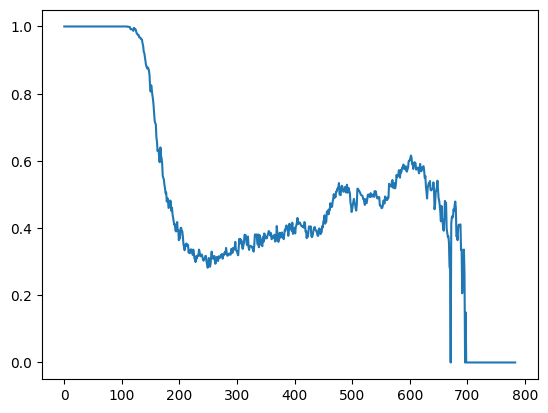

In [ ]:
plt.plot(percent_stable_arr)
plt.show()

In [ ]:
num_test = 1000
N = p.shape[-1]
num_flip = 100
# p_target = np.array(p[0])
p_corrupt = np.ones((num_test, N)) * np.array(p[0])

for i in range(num_test):
  flips = np.random.choice(N, num_flip, replace=False)
  p_corrupt[i, flips] *= -1
p_corrupt = jnp.array(p_corrupt)

In [ ]:
percent_stable_arr_2 = np.zeros(N)
percent_stable_arr_2[0] = 1
for i in range(1, N):
  W = pseudo_inv(p[:i])
  x = simulate_ein(p_corrupt, W, num_iters=20)
  is_stable = jnp.all(x[-1] == p[0], axis=-1)
  percent_stable = is_stable.sum() / len(is_stable)
  print(i, percent_stable)
  percent_stable_arr_2[i] = percent_stable

1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 0.999
44 0.999
45 0.999
46 0.999
47 0.999
48 1.0
49 0.999
50 1.0
51 1.0
52 1.0
53 1.0
54 1.0
55 1.0
56 1.0
57 0.999
58 0.998
59 0.998
60 0.997
61 0.998
62 0.998
63 0.998
64 0.997
65 0.997
66 0.997
67 0.996
68 0.997
69 0.996
70 0.997
71 0.995
72 0.996
73 0.995
74 0.994
75 0.993
76 0.993
77 0.991
78 0.991
79 0.988
80 0.987
81 0.989
82 0.989
83 0.987
84 0.987
85 0.983
86 0.977
87 0.973
88 0.968
89 0.968
90 0.961
91 0.954
92 0.946
93 0.935
94 0.933
95 0.929
96 0.923
97 0.92
98 0.909
99 0.898
100 0.884
101 0.855
102 0.848
103 0.844
104 0.838
105 0.821
106 0.808
107 0.781
108 0.726
109 0.698
110 0.679
111 0.665
112 0.623
113 0.605
114 0.588
115 0.515
116 0.483
117 0.428
118 0.417
119 0.398
120 0.389
121 0.428

KeyboardInterrupt: 

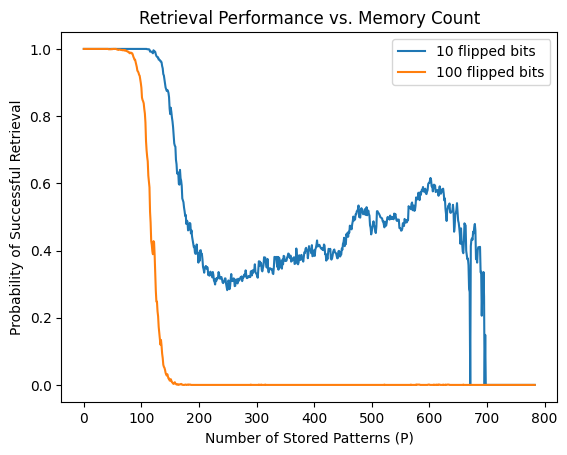

In [ ]:
plt.plot(percent_stable_arr, label='10 flipped bits')
plt.plot(percent_stable_arr_2, label='100 flipped bits')
plt.xlabel('Number of Stored Patterns (P)')
plt.ylabel('Probability of Successful Retrieval')
plt.title('Retrieval Performance vs. Memory Count')
plt.legend()
plt.show()

In [ ]:
jnp.flatnonzero(percent_stable_arr_2 != 1)

Array([ 43,  44,  45,  46,  47,  49,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 23

### Misc

In [ ]:
# verify that state evolves for non equilibrium states
num_test = 10
test_patterns = generate_random_pattern(jr.PRNGKey(10), (num_test, 25))
for x_0 in test_patterns:
  x = simulate(x_0, W, num_iters=30000)
  print(jnp.all(x == x[-1]), check_pattern(x[-1], p))

False True
False True
False True
False True
False True
False True
False True
False True
False True
False True


False True


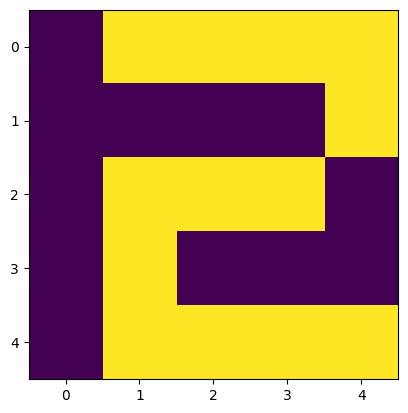

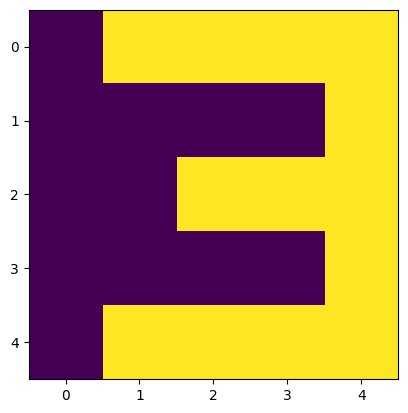

In [ ]:
x_0 = two_pattern

x = simulate(x_0, W, num_iters=1)
print(jnp.all(x == x[-1]), check_pattern(x[-1], p))

for xi in x:
  plt.imshow(xi.reshape((5, 5)))
  plt.show()

In [ ]:
p_star = get_nearest_pattern(A, p)

num_train = 1000
A_learned = A + num_train * p_star

In [ ]:
x = simulate(A_learned, W / 10, -A_learned)
print(jnp.all(x == A_learned), jnp.all(x == -A_learned))

False False


#### Store 3, 4, 5, 6

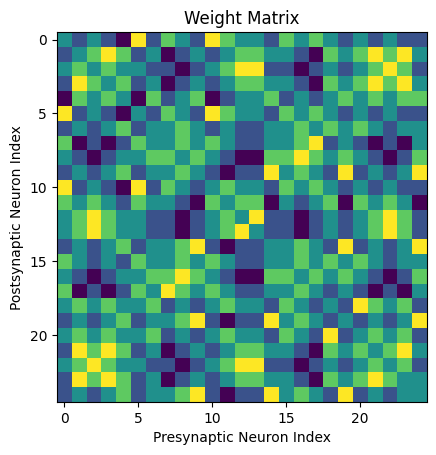

In [ ]:
W = hebbian_weights(p)

plt.imshow(W, interpolation='none')
plt.title('Weight Matrix')
plt.xlabel('Presynaptic Neuron Index')
plt.ylabel('Postsynaptic Neuron Index')
plt.show()

In [ ]:
# veryify that patterns are equilibria
for x_0 in p:
  x = simulate(x_0, W)
  print(jnp.all(x[-1] == x_0))

True
True
True
True


In [ ]:
@partial(jit, static_argnames='num_iters')
def simulate_ein(x_0, W, b=0, dt=.1, num_iters=100000):
    def _step(x_t, b_t):
      x_tp1 = sign(jnp.einsum('ij,...i->...j', W, x_t) - b_t)
      return x_tp1, x_tp1

    N = x_0.shape[-1]
    b = jnp.zeros((num_iters, *x_0.shape))
    _, x = jax.lax.scan(_step, x_0, b)
    x = jnp.r_[x_0[jnp.newaxis], x]
    return x

In [ ]:
key = jr.PRNGKey(0)
n_test = 2000
unifs = jr.uniform(key, (n_test, 25))
num_iters = 16
probs = []
match_times = []
dists = []

for n in range(26):
  prob = n / 25
  mask = 2. * (unifs > prob) - 1
  x0 = mask * p[1]
  x = simulate_ein(x0, W, num_iters=num_iters)

  matches = (x == p[1]).all(-1) #| (x == -p[1]).all(-1)
  match_time = num_iters + 1 - matches.sum(0)

  probs.append(prob)
  dists.append((unifs < prob).sum(-1))
  match_times.append(match_time)

dists = jnp.array(dists)
match_times = jnp.array(match_times)
probs = jnp.array(probs)

In [ ]:
2000

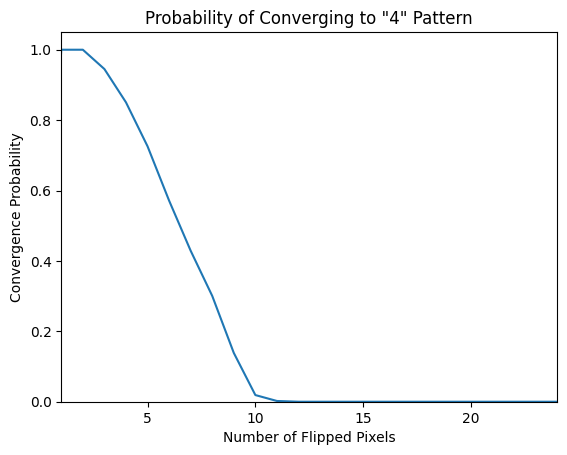

In [ ]:
match_probs = np.zeros((26))
for n in range(1, 25):
  mask = dists == n
  count = mask.sum()
  trials = match_times[mask]
  match_probs[n] = (match_times[mask] != (num_iters + 1)).sum() / count

plt.plot(match_probs)
plt.ylim(0, 1.05)
plt.xlim(1, 24)
plt.ylabel('Convergence Probability')
plt.xlabel('Number of Flipped Pixels')
plt.title('Probability of Converging to "4" Pattern')
plt.show()

In [ ]:
match_probs

array([0.        , 1.        , 1.        , 0.94509596, 0.85049659,
       0.72564507, 0.57128155, 0.42888522, 0.30057502, 0.13863404,
       0.01891616, 0.00211416, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [ ]:
unique_match_times = np.sort(np.unique(match_times))[1:-1]
unique_match_times

array([1, 2, 3, 4, 5], dtype=int32)

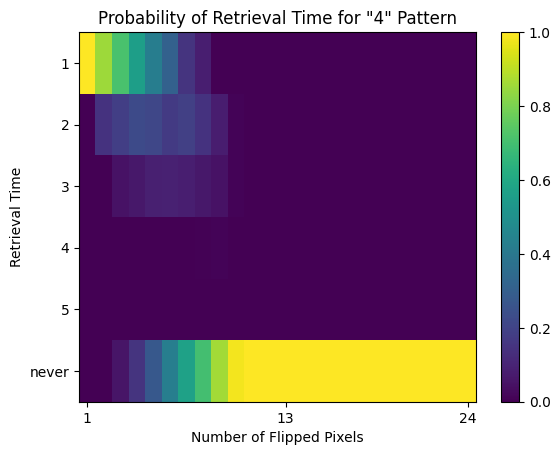

In [ ]:
match_probs = np.zeros((26))
probs = np.zeros((24, len(unique_match_times) + 1))
ns = []
for n in range(1, 25):
  mask = dists == n
  trials = match_times[mask]
  for i, t in enumerate(unique_match_times):
    probs[n - 1, i] = (trials == t).sum() / len(trials)
  probs[n - 1, -1] = (trials > unique_match_times[-1]).sum() / len(trials)
  # probs[n - 1, 3] = (trials > 3).sum() / len(trials)
plt.title('Probability of Retrieval Time for "4" Pattern')
plt.imshow(probs.T, aspect='auto', vmin=0, vmax=1)
plt.yticks(range(6), ['1', '2', '3', '4', '5', 'never'])
plt.ylabel('Retrieval Time')
xticks = np.array([0, 12, 23])
plt.xticks(xticks, xticks + 1)
plt.xlabel('Number of Flipped Pixels')
plt.colorbar()
plt.show()

In [ ]:
np.arange(24)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

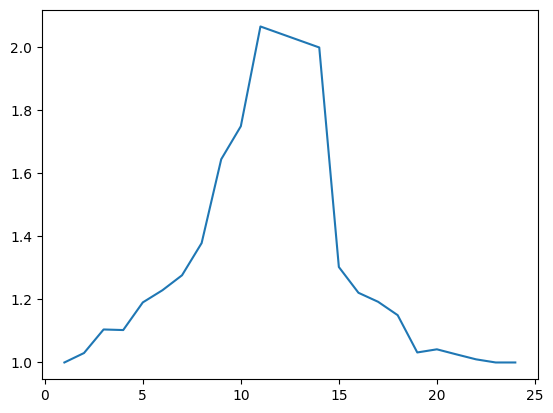

In [ ]:
match_probs = np.zeros((26))
mean_times = []
ns = []
for n in range(1, 25):
  mask = dists == n
  trials = match_times[mask]
  convergence_trials = trials[trials < 10]
  if len(convergence_trials):
    ns.append(n)
    mean_times.append(convergence_trials.mean())
    # plt.violinplot(convergence_trials, [n], c='blue')

# plt.ylim(0, 1.05)
# plt.xlim(0, 25)
# plt.ylabel('Convergence Probability')
# plt.xlabel('Number of Flipped Pixels')
# plt.title('Probability of Converging to "4" Pattern')
plt.plot(ns, mean_times)
plt.show()

In [ ]:
np.unique(match_times)

array([ 0,  1,  2,  3, 11], dtype=int32)

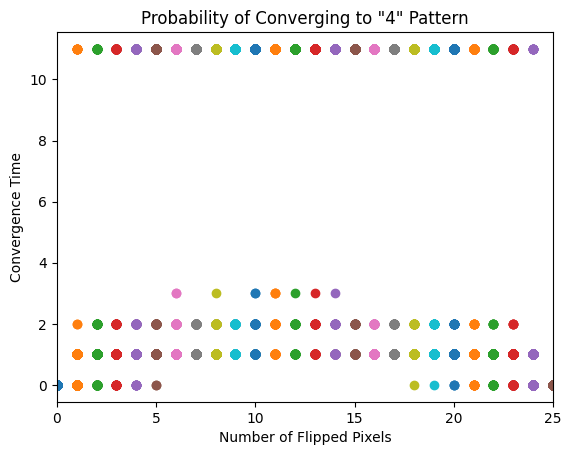

In [ ]:
match_probs = []
for prob, match_time in zip(probs, match_times):
  plt.scatter(jnp.full_like(match_time, prob * 25), match_time)

plt.xlim(0, 25)
plt.ylabel('Convergence Time')
plt.xlabel('Number of Flipped Pixels')
plt.title('Probability of Converging to "4" Pattern')
plt.show()